In [1]:
#1, pull the new feature_gradients code - DONE
#2, run a model with feature gradients 
#3, implement the current CRISP loop

In [2]:
import os
import pandas as pd
while os.getcwd() != '/home/jupyter/crisp':
    os.chdir("..")
%pwd

'/home/jupyter/crisp'

In [3]:
from models.SimpleNonLinearInvariantRiskMinimization import SimpleNonLinearInvariantRiskMinimization
from dataio.DataFrameDataset import *
from dataio.datasets import *

In [4]:
from models.LinearInvariantRiskMinimization import LinearInvariantRiskMinimization


In [5]:
from synthetic.facebook_synthetic_data_generator import generator_example

dim_inv = 6
dim_spu = 60
n_exp_train = 1000 #int(2e2)
n_exp_test = 300
n_env = 5
save_dir = 'data/synthetic'

In [6]:
config = {
    "name": "Example Experiment for AH casual ensemble",
    "short_name": "ah_experiment_notebook",
    "bucket_project": "fdl-us-astronaut-health",
    "bucket_name": "ah_21_data",
    "bucket_path": "gs://ah_21_data",
    "verbose": 1,
    "test_val_split": [0.1, 0.1],
    "per_variant_experiment": False,
    "data_options": {
        #'dataset_fp': '../data/test_multiclass.pkl',
        'dataset_fp' : None,
        'output_data_regime' : ["real-valued", "binary", "binary", "real-valued", "multi-class"],
        'subject_keys': 'Subj_ID',
        'targets': ['Target'],
 #        'predictors': ['All'],
        'predictors': None,
        'environments': ['env_split'],
        'exclude': ['Subj_ID'],
        'synthetic_train_test_split' : True,
    },
    "feature_selection_options": {
        "max_features": 20,
        "verbose": 0,
        "seed": 12
    },
    "ensemble_options": {
        "models": ["ERM", "RF", "ICP", "IRM", "DCF", "ITE", "LIRM", "NLICP"]
    },
    "use_cloud":False,
    "results_directory": "results/"
}
data_config = config['data_options']

In [7]:
LIRM_options = config.get("ensemble_options").get('LIRM', {})
LIRM_args = {
            "use_icp_initialization": False,
            "verbose": 0,
            "n_iterations": 100, # 1000
            "seed": 1,
            "lr": 0.005, # 0.001
            "cuda": False
        }
LIRM_args.update(LIRM_options)

In [8]:
def get_dataset_for_synthetic_experiment(n_example, dim_inv, dim_spu, n_exp_train, n_exp_test, n_env, save_dir):
    # training data
    generator_example(n_example, dim_inv, dim_spu, n_exp_train, n_env ,save_dir, False)
    outfile_train = os.path.join(save_dir,"data_fb_example_%s_dim_inv_%s_dim_spu_%s_n_exp_%s_n_env_%s_test_%s.pickle" %(n_example, dim_inv, dim_spu, n_exp_train, n_env, False))

    # test data
    generator_example(n_example, dim_inv, dim_spu, n_exp_test, n_env ,save_dir, True)
    outfile_test = os.path.join(save_dir,"data_fb_example_%s_dim_inv_%s_dim_spu_%s_n_exp_%s_n_env_%s_test_%s.pickle" %(n_example, dim_inv, dim_spu, n_exp_test, n_env, True))
    
    return outfile_train, outfile_test

In [9]:
snlirm_results = {}

for n_example in [1]:#,2,3,4,5]:
    output_data_regime = config["data_options"]["output_data_regime"][n_example-1]
    print("\n\nn_example:", n_example, "output_data_regime:", output_data_regime, "\n\n")
    
    outfile_train, outfile_test = get_dataset_for_synthetic_experiment(n_example, dim_inv, dim_spu, n_exp_train, n_exp_test, n_env, save_dir)
    df_train = pd.read_pickle(outfile_train)
    df_test = pd.read_pickle(outfile_test)

    config["data_options"]["dataset_fp_train"] = outfile_train
    config["data_options"]["dataset_fp_test"] = outfile_test
    config["data_options"]["predictors"] = list(df_train.columns[0:dim_inv+dim_spu])
    environment_datasets, val_dataset, test_dataset = get_datasets_for_experiment(config)

    LIRM_args["target"] = config["data_options"]["targets"]
    LIRM_args["output_data_regime"] = output_data_regime
    LIRM_args["columns"] = test_dataset.predictor_columns
    LIRM_args['output_dim'] = 1
    
    snlirm = SimpleNonLinearInvariantRiskMinimization(environment_datasets, val_dataset, test_dataset, LIRM_args)
    
    snlirm_results_dict = snlirm.results()
    snlirm_results[n_example] = snlirm_results_dict



n_example: 1 output_data_regime: real-valued 


Environments variables: {'E0': 0.1, 'E1': 1.5, 'E2': 2, 'E3': 0.30815539086172433, 'E4': 2.016811860476012}
Generated Synthetic Data according to the Facebook setup Example: 1
     df with  66  columns
Environments variables: {'E0': 0.1, 'E1': 1.5, 'E2': 2, 'E3': 0.30815539086172433, 'E4': 2.016811860476012}
Generated Synthetic Data according to the Facebook setup Example: 1
     df with  66  columns
Running a per sample experiment
Using synthetic dataset train/test split
Loaded  5  train environments
Env  0  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  1  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  2  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  3  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  4  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Loaded test set, X shape: (300, 66)  y shape:  (300, 1)
Start simple nonlinear-IRM training procedure
input_gradients: torc

In [10]:
lirm_results = {}

for n_example in [1]:#,2,3,4,5]:
    output_data_regime = config["data_options"]["output_data_regime"][n_example-1]
    print("\n\nn_example:", n_example, "output_data_regime:", output_data_regime, "\n\n")
    
    outfile_train, outfile_test = get_dataset_for_synthetic_experiment(n_example, dim_inv, dim_spu, n_exp_train, n_exp_test, n_env, save_dir)
    df_train = pd.read_pickle(outfile_train)
    df_test = pd.read_pickle(outfile_test)

    config["data_options"]["dataset_fp_train"] = outfile_train
    config["data_options"]["dataset_fp_test"] = outfile_test
    config["data_options"]["predictors"] = list(df_train.columns[0:dim_inv+dim_spu])
    environment_datasets, val_dataset, test_dataset = get_datasets_for_experiment(config)

    LIRM_args["target"] = config["data_options"]["targets"]
    LIRM_args["output_data_regime"] = output_data_regime
    LIRM_args["columns"] = test_dataset.predictor_columns
    LIRM_args['output_dim'] = 1
    
    lirm = LinearInvariantRiskMinimization(environment_datasets, val_dataset, test_dataset, LIRM_args)
    
    lirm_results_dict = lirm.results()
    lirm_results[n_example] = lirm_results_dict



n_example: 1 output_data_regime: real-valued 


Environments variables: {'E0': 0.1, 'E1': 1.5, 'E2': 2, 'E3': 0.30815539086172433, 'E4': 2.016811860476012}
Generated Synthetic Data according to the Facebook setup Example: 1
     df with  66  columns
Environments variables: {'E0': 0.1, 'E1': 1.5, 'E2': 2, 'E3': 0.30815539086172433, 'E4': 2.016811860476012}
Generated Synthetic Data according to the Facebook setup Example: 1
     df with  66  columns
Running a per sample experiment
Using synthetic dataset train/test split
Loaded  5  train environments
Env  0  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  1  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  2  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  3  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Env  4  has  200  samples
X shape  (200, 66)  y shape  (200, 1)
Loaded test set, X shape: (300, 66)  y shape:  (300, 1)
Start IRM training procedure with real-valued target
input_gradient

In [11]:
snlirm.results()['to_bucket']['method']

input_gradients: torch.Size([1000, 66])


'Simple Non-Linear IRM'

In [12]:
lirm.results()['to_bucket']['method']

input_gradients: torch.Size([1000, 66])


'Linear IRM'

In [13]:
# snlirm.results()['to_bucket']['coefficients']

In [14]:
# snlirm.results()['to_bucket']['features']

In [15]:
# snlirm.results()['to_bucket']['feature_gradients']

In [16]:
# lirm.results()['to_bucket']['feature_gradients']

In [17]:
from utils.new_get_ensemble_results import get_ensemble_results

In [18]:
coef_method = get_ensemble_results([snlirm.results()['to_bucket'],lirm.results()['to_bucket']], use_feature_gradients = True)
grad_method = get_ensemble_results([snlirm.results()['to_bucket'],lirm.results()['to_bucket']], use_feature_gradients = False)

input_gradients: torch.Size([1000, 66])
input_gradients: torch.Size([1000, 66])
input_gradients: torch.Size([1000, 66])
input_gradients: torch.Size([1000, 66])


/home/jupyter/crisp/utils/new_get_ensemble_results.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_weight_df[method][feat_df['feature']] = feat_df['coefficient'].values
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/home/jupyter/crisp/utils/new_get_ensemble_results.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

In [19]:
coef_method.sort_values('weighted_coefficient', ascending = False)

,Simple Non-Linear IRM,Linear IRM,count_models,selected,weighted_coefficient,feature
Causal_4,0.010992,0.984473,2,1.0,0.497732,Causal_4
Causal_0,0.008992,0.582916,2,1.0,0.295954,Causal_0
Non_causal_34,0.007892,0.562575,2,1.0,0.285234,Non_causal_34
Non_causal_39,0.007512,0.561235,2,1.0,0.284373,Non_causal_39
Causal_1,0.006719,0.537797,2,1.0,0.272258,Causal_1
...,...,...,...,...,...,...
Non_causal_45,0.011547,0.010685,2,1.0,0.011116,Non_causal_45
Non_causal_13,0.008486,0.006094,2,1.0,0.007290,Non_causal_13
Non_causal_46,0.006731,0.006018,2,1.0,0.006375,Non_causal_46
Non_causal_28,0.007246,0.005409,2,1.0,0.006328,Non_causal_28


In [20]:
grad_method.sort_values('weighted_coefficient', ascending = False)

,Simple Non-Linear IRM,Linear IRM,count_models,selected,weighted_coefficient,feature
Non_causal_31,2.020267,-0.168912,2,1.0,0.925677,Non_causal_31
Non_causal_35,1.466698,0.301430,2,1.0,0.884064,Non_causal_35
Non_causal_38,1.740356,-0.393637,2,1.0,0.673360,Non_causal_38
Non_causal_36,1.324082,-0.045449,2,1.0,0.639316,Non_causal_36
Non_causal_54,1.408693,-0.182924,2,1.0,0.612885,Non_causal_54
...,...,...,...,...,...,...
Non_causal_32,-1.034278,-0.164048,2,1.0,-0.599163,Non_causal_32
Non_causal_45,-1.457965,0.087595,2,1.0,-0.685185,Non_causal_45
Non_causal_30,-2.013245,0.443916,2,1.0,-0.784665,Non_causal_30
Non_causal_37,-2.619317,0.948573,2,1.0,-0.835372,Non_causal_37


In [21]:
grad_method.weighted_coefficient / grad_method.weighted_coefficient.abs().max()

Non_causal_9     0.347204
Non_causal_53    0.437957
Non_causal_5     0.343801
Non_causal_33   -0.033820
Non_causal_27    0.186899
                   ...   
Non_causal_24    0.529471
Non_causal_18   -0.144560
Non_causal_25    0.446420
Non_causal_8    -0.617945
Non_causal_26    0.045246
Name: weighted_coefficient, Length: 66, dtype: float64

In [29]:
dry_run = lirm.test_dataset.get_all()[0]
inputs = torch.cat((torch.ones(dry_run.size(0), 1), dry_run), 1)

In [50]:
lirm.phi(inputs[0:100]).shape

torch.Size([100, 67])

In [84]:
pred_function = torch.matmul(lirm.phi,lirm.w)

TypeError: matmul(): argument 'input' (position 1) must be Tensor, not Linear

In [78]:
e = shap.DeepExplainer(pred_function, inputs[0:200])

AssertionError: <class 'function'> is not currently a supported model type!

In [72]:
e = shap.DeepExplainer(lirm.phi, inputs[0:200])

In [73]:
x_samples = inputs[200:300]
print(len(x_samples))
shap_values = e.shap_values(x_samples)

100


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [57]:
# (lirm.results()['to_bucket']['features'][0:60])

input_gradients: torch.Size([1000, 66])


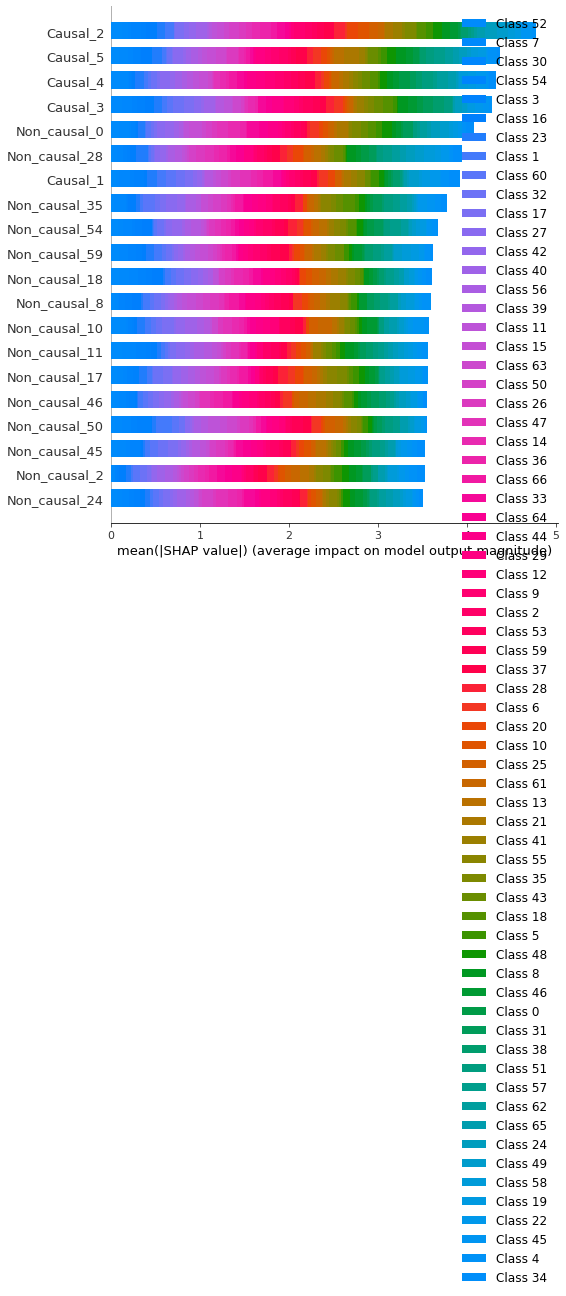

In [75]:
shap.summary_plot(shap_values, features=x_samples, feature_names=lirm.results()['to_bucket']['features'])